# Dynamical Magnetic Xray Scattering

In this example static and transient magnetic X-ray simulations are carried out employing a dynamical magnetic X-ray scattering formalism which was adapdet from [Project Dyna](https://neel.cnrs.frspip.php/?rubrique1008).

## Setup

Do all necessary imports and settings.

In [1]:
import udkm1Dsim as ud
u = ud.u #  import the pint unit registry from udkm1Dsim
import scipy.constants as constants
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib() #  use matplotlib with pint units

## Structure

Refere to the [structure-example](structure.ipynb) for more details.

In this example the sample `Structure` consists of `AmorphousLayer`s.

In order to build an antiferromagntic sample two different types of _Fe_ `Atom`s and `AmorphousLayer`s are created with opposite in-plane magnetization.

Here a local file for the atomic scattering factor is read only for Fe atoms.

In [96]:
Fe_right = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=90*u.deg,
                  atomic_form_factor_path='./Fe.cf')
Fe_left = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=270*u.deg,
                  atomic_form_factor_path='./Fe.cf')
Cr = ud.Atom('Cr')
Si = ud.Atom('Si')

In [97]:
density_Fe = 7874*u.kg/u.m**3

prop_Fe = {}
prop_Fe['heat_capacity'] = 449*u.J/u.kg/u.K
prop_Fe['therm_cond'] = 80*u.W/(u.m *u.K)
prop_Fe['lin_therm_exp'] = 11.8e-6
prop_Fe['sound_vel'] = 4.910*u.nm/u.ps
prop_Fe['opt_ref_index'] = 2.9174+3.3545j


layer_Fe_left = ud.AmorphousLayer('Fe_left', 'Fe left amorphous', 1*u.nm, density_Fe, atom=Fe_left, **prop_Fe)
layer_Fe_right = ud.AmorphousLayer('Fe_right', 'Fe right amorphous', 1*u.nm, density_Fe, atom=Fe_right, **prop_Fe)

In [98]:
density_Cr = 7140*u.kg/u.m**3

prop_Cr = {}
prop_Cr['heat_capacity'] = 449*u.J/u.kg/u.K
prop_Cr['therm_cond'] = 94*u.W/(u.m *u.K)
prop_Cr['lin_therm_exp'] = 6.2e-6
prop_Cr['sound_vel'] = 5.940*u.nm/u.ps
prop_Cr['opt_ref_index'] = 3.1612+3.4606j

layer_Cr = ud.AmorphousLayer('Cr', "Cr amorphous", 1*u.nm, density_Cr, atom=Cr, **prop_Cr)

In [99]:
density_Si = 2336*u.kg/u.m**3

prop_Si = {}
prop_Si['heat_capacity'] = 703*u.J/u.kg/u.K
prop_Si['therm_cond'] = 150*u.W/(u.m *u.K)
prop_Si['lin_therm_exp'] = 2.6e-6
prop_Si['sound_vel'] = 8.433*u.nm/u.ps
prop_Si['opt_ref_index'] = 3.6941+0.0065435j

layer_Si = ud.AmorphousLayer('Si', "Si amorphous", 1*u.nm, density_Si, atom=Si, **prop_Si)

In [100]:
S = ud.Structure('Fe/Cr AFM Super Lattice')

# create a sub-structure
DL = ud.Structure('Two Fe/Cr Double Layers')
DL.add_sub_structure(layer_Fe_left, 1)
DL.add_sub_structure(layer_Cr, 1)
DL.add_sub_structure(layer_Fe_right, 1)
DL.add_sub_structure(layer_Cr, 1)

S.add_sub_structure(DL, 10)
S.add_sub_structure(layer_Fe_left, 10)
S.add_sub_structure(layer_Si, 100)

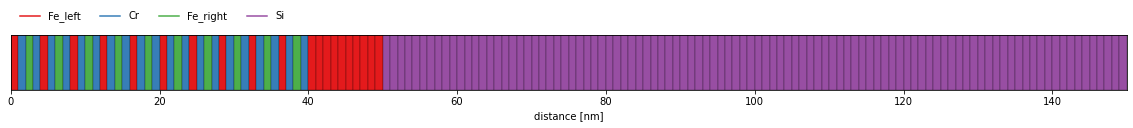

In [101]:
S.visualize()

## Structure creation

Create an actual sample using the `Structure` class and add `UnitCell` objects to it.

## Heat

Refere to the [heat-example](heat.ipynb) for more details.

In [102]:
h = ud.Heat(S, True)

h.save_data = False
h.disp_messages = True

h.excitation = {'fluence': [35]*u.mJ/u.cm**2,
                'delay_pump':  [0]*u.ps,
                'pulse_width':  [0]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 45*u.deg}

# enable heat diffusion
h.heat_diffusion = True

# temporal and spatial grid
delays = np.r_[-1:20:0.1]*u.ps
_, _, distances = S.get_distances_of_layers()

In [103]:
temp_map, delta_temp_map = h.get_temp_map(delays, 300*u.K)

Elapsed time for _temperature_after_delta_excitation_: 0.056046 s
Calculating _heat_diffusion_ ...



Elapsed time for _heat_diffusion_: 10.469637 s
Elapsed time for _temp_map_: 10.561398 s


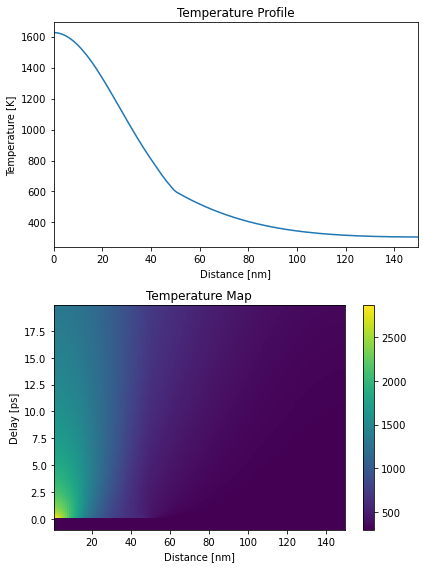

In [104]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, temp_map[101, :])
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Temperature [K]')
plt.title('Temperature Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map)
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map')

plt.tight_layout()
plt.show()

## Numerical Phonons

Refere to the [phonons-example](phonons.ipynb) for more details.

In [105]:
p = ud.PhononNum(S, True)
p.save_data = False
p.disp_messages = True

In [106]:
strain_map = p.get_strain_map(delays, temp_map, delta_temp_map)

Calculating linear thermal expansion ...
Calculating coherent dynamics with ODE solver ...



Elapsed time for _strain_map_: 0.822862 s


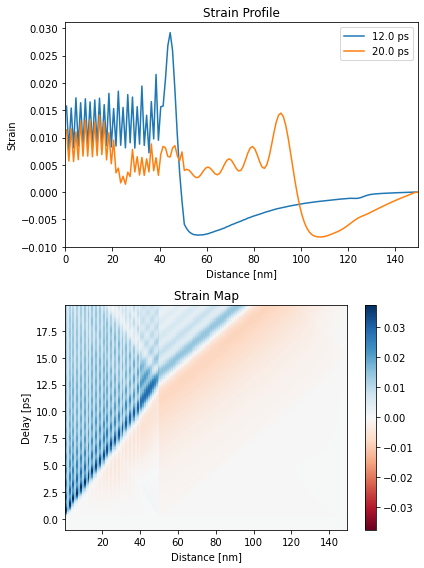

In [109]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, strain_map[130, :], label=np.round(delays[130]))
plt.plot(distances.to('nm').magnitude, strain_map[-1, :], label=np.round(delays[-1]))
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Strain')
plt.legend()
plt.title('Strain Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude,
               strain_map, cmap='RdBu',
               vmin=-np.max(strain_map), vmax=np.max(strain_map))
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Strain Map')

plt.tight_layout()
plt.show()

## Initialize dynamical magnetic X-ray simulations

The `XrayDynMag` class requires a `Structure` object and a boolean `force_recalc` in order overwrite previous simulation results.

These results are saved in the `cache_dir` when `save_data` is enabled.
Printing simulation messages can be en-/disabled using `disp_messages` and progress bars can using the boolean switch `progress_bar`.

In [110]:
dyn_mag = ud.XrayDynMag(S, True)
dyn_mag.disp_messages = True
dyn_mag.save_data = False

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized


## Homogeneous magnetic X-ray scattering

For the case of homogeneously strained/magnetized samples, the dynamical magnetic X-ray scattering simulations can be greatly simplyfied, which saves a lot of computational time.

### $q_z$-scan

The `XrayDynMag` object requires an `energy` and scattering vector `qz` to run the simulations.  
Both parameters can be arrays and the resulting reflectivity has a first dimension for the photon energy and the a second for the scattering vector.

The resulting reflectivity is always calculated for the actual magnetization (`R_hom`) of the sample, as well as for opposite magnetization (`R_hom_phi`).

In [111]:
dyn_mag.energy = np.r_[600, 710]*u.eV #  set two photon energies
dyn_mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range

R_hom, R_hom_phi = dyn_mag.homogeneous_reflectivity() #  this is the actual calculation

Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.379934 s


In this example half-order antiferromagnetic Bragg peaks appear only at the resonance.

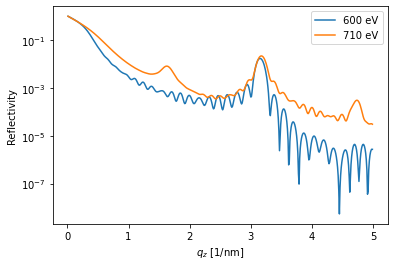

In [112]:
plt.figure()
plt.semilogy(dyn_mag.qz[0, :], R_hom[0, :], label='{}'.format(dyn_mag.energy[0]))
plt.semilogy(dyn_mag.qz[1, :], R_hom[1, :], label='{}'.format(dyn_mag.energy[1]))
plt.ylabel('Reflectivity')
plt.xlabel(r'$q_z$ [1/nm]')
plt.legend()
plt.show()

### Post-Processing

Simple convolution of the results with an arbitrary function handle.

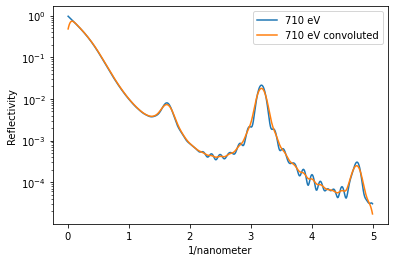

In [113]:
FWHM = 0.01/1e-10 # Angstrom
sigma = FWHM /2.3548
        
handle = lambda x: np.exp(-((x)/sigma)**2/2)
y_conv = dyn_mag.conv_with_function(R_hom[1,:], dyn_mag._qz[1,:], handle)

plt.figure()
plt.semilogy(dyn_mag.qz[0,:], R_hom[1,:], label='{}'.format(dyn_mag.energy[1]))
plt.semilogy(dyn_mag.qz[0,:], y_conv, label='{} convoluted'.format(dyn_mag.energy[1]))
plt.ylabel('Reflectivity')
plt.legend()
plt.show()

### Energy- and $q_z$-scan

In [114]:
dyn_mag.energy = np.r_[690:730:0.1]*u.eV #  set the energy range
dyn_mag.qz = np.r_[0.01:5:0.01]/u.nm # qz range

R_hom, R_hom_phi = dyn_mag.homogeneous_reflectivity() #  this is the actual calculation

Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 65.704006 s


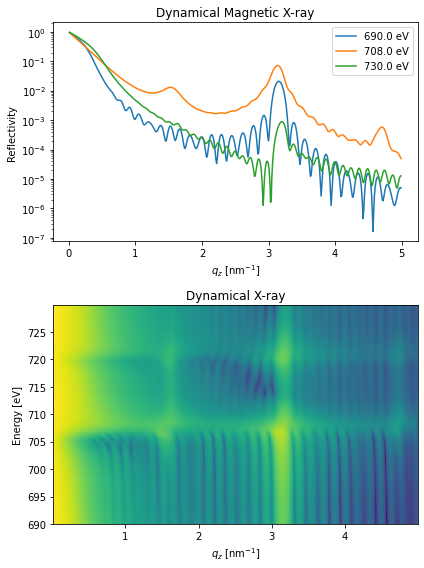

In [116]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_hom[0, :], label=np.round(dyn_mag.energy[0]))
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_hom[180, :], label=np.round(dyn_mag.energy[180]))
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_hom[-1, :], label=np.round(dyn_mag.energy[-1]))

plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.ylabel('Reflectivity')
plt.legend()
plt.title('Dynamical Magnetic X-ray')

plt.subplot(2, 1, 2)
plt.pcolormesh(dyn_mag.qz[0, :].to('1/nm').magnitude, dyn_mag.energy.magnitude, np.log10(R_hom[:, :]))
plt.title('Dynamical X-ray')
plt.ylabel('Energy [eV]')
plt.xlabel('$q_z$ [nm$^{-1}$]')

plt.tight_layout()
plt.show()

## Inhomogeneous dynamical magnetic X-ray scattering

The `inhomogeneous_reflectivity()` method allows to calculate the transient magnetic X-ray reflectivity according to a `strain_map` and/or `magnetization_map`.

In [117]:
dyn_mag.energy = np.r_[708]*u.eV #  set the energy range
dyn_mag.qz = np.r_[0.01:5:0.01]/u.nm # qz range

magnetization_map = np.zeros([len(delays), S.get_number_of_layers(), 3])

R_seq, R_seq_phi = dyn_mag.inhomogeneous_reflectivity(strain_map, magnetization_map)

Calculating _inhomogeneous_reflectivity_ ...



Elapsed time for _inhomogeneous_reflectivity_: 404.934561 s


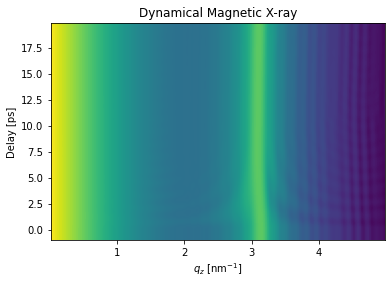

In [118]:
plt.figure()
plt.pcolormesh(dyn_mag.qz[0, :].to('1/nm').magnitude, delays.to('ps').magnitude, np.log10(R_seq[:, 0, :]))
plt.title('Dynamical Magnetic X-ray')
plt.ylabel('Delay [ps]')
plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.show()

## Parallel dynamical Xray scattering

Parallelization needs still to be implemented, but will work similarly as with XrayDyn.

You need to install the `udkm1Dsim` with the `parallel` option which essentially add the Dask package to the requirements:

```
> pip install udkm1Dsim[parallel]
```

You can also install/add Dask manually, e.g. via pip:

```
> pip install dask
```

Please refer to the [Dask documentation](https://docs.dask.org/en/latest/) for more details on parallel computing in Python.


c:\users\schick\general\python\wpy64-3770\python-3.7.7.amd64\lib\site-packages\distributed\dashboard\core.py:79: UserWarning: 
Failed to start diagnostics server on port 8787. [WinError 10048] Normalerweise darf jede Socketadresse (Protokoll, Netzwerkadresse oder Anschluss) nur jeweils einmal verwendet werden
  warnings.warn("\n" + msg)


Calculating _inhomogeneous_reflectivity_ ...
Elapsed time for _inhomogeneous_reflectivity_: 43.210175 s


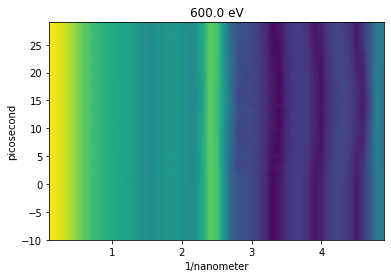

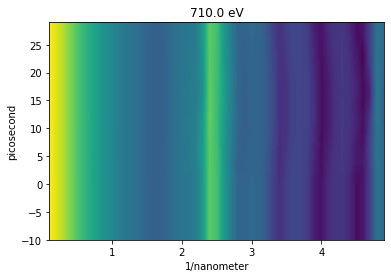

In [12]:
try:
    from dask.distributed import Client
    client = Client()

    R_seq, R_seq_phi = mag.inhomogeneous_reflectivity(strain_map, magnetization_map, calc_type='parallel', dask_client=client)

    for i, energy in enumerate(mag.energy):
        plt.figure()
        plt.contourf(mag.qz[i,:], delays, np.log10(R_seq[:, i, :]), levels=100)
        plt.title('{:0.1f} eV'.format(energy.magnitude))
        plt.show()
except:
    pass

## Polarization Dependence

### Non-Magnetic sample

The current sample is currently not magnetic, therefore, there should no scattering from sigma to pi and vice versa.

incoming polarizations set to: sigma
analyzer polarizations set to: sigma
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.702023 s
incoming polarizations set to: sigma
analyzer polarizations set to: pi
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.664002 s


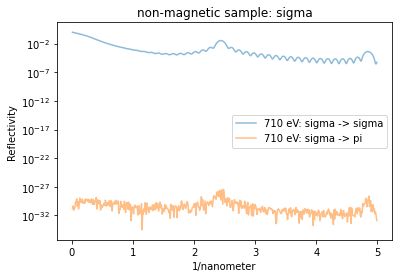

In [13]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(3, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> sigma'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> pi'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('non-magnetic sample: sigma')
plt.legend()
plt.show()

incoming polarizations set to: pi
analyzer polarizations set to: pi
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.709959 s
incoming polarizations set to: pi
analyzer polarizations set to: sigma
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.684168 s


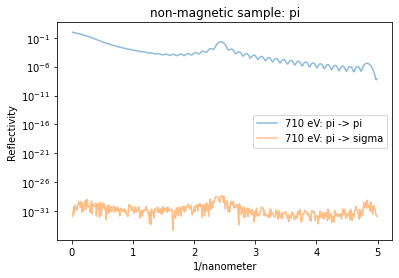

In [14]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(4, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> pi'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(4, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> sigma'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('non-magnetic sample: pi')
plt.legend()
plt.show()

### Magnetic Sample

Now compare the scattering with a ferromagnetic and antiferromagnetic sample structure.

In [15]:
# Fe atom with magnetization in-plane to the left
Fe_left = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=90*u.deg, id='Fe left')
# Fe atom with magnetization in-plane to the right
Fe_right = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=270*u.deg, id='Fe right')

# Fe unit cell with left in-plane magnetization
Fe_uc_left = ud.UnitCell('Fe_left', 'Fe', c_Fe, **propFe)
Fe_uc_left.add_atom(Fe_left, 0)
Fe_uc_left.add_atom(Fe_left, 0.5)

# Fe unit cell with right in-plane magnetization
Fe_uc_right = ud.UnitCell('Fe_right', 'Fe', c_Fe, **propFe)
Fe_uc_right.add_atom(Fe_right, 0)
Fe_uc_right.add_atom(Fe_right, 0.5)

#### FM Sample

In [16]:
N_Fe = 5
N_Cr = 4

SFM = ud.Structure('FM Super Lattice')

DLFM = ud.Structure('FM Double Layer Fe+Cr')
DLFM.add_sub_structure(Fe_uc_left, N_Fe)
DLFM.add_sub_structure(Cr_uc, N_Cr)

SFM.add_sub_structure(DLFM, 20)

# add Si substrate
SFM.add_substrate(substrate)

distances, _, _ = SFM.get_distances_of_layers() # distance vector of all unit cells

mag.S = SFM # replace the sample in the current simulation

incoming polarizations set to: sigma
analyzer polarizations set to: sigma
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.686250 s
incoming polarizations set to: sigma
analyzer polarizations set to: pi
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.656439 s


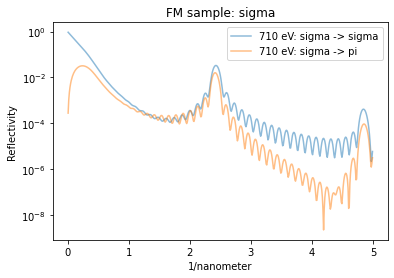

In [17]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(3, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> sigma'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> pi'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('FM sample: sigma')
plt.legend()
plt.show()

incoming polarizations set to: pi
analyzer polarizations set to: pi
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.723887 s
incoming polarizations set to: pi
analyzer polarizations set to: sigma
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.686482 s


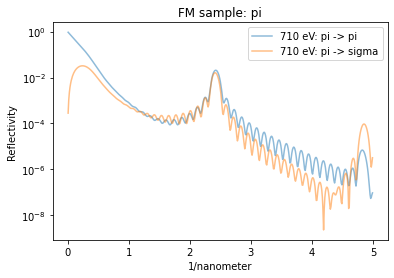

In [18]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(4, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> pi'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(4, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> sigma'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('FM sample: pi')
plt.legend()
plt.show()

incoming polarizations set to: circ +
analyzer polarizations set to: unpolarized
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.672994 s
incoming polarizations set to: circ -
analyzer polarizations set to: unpolarized
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.556928 s


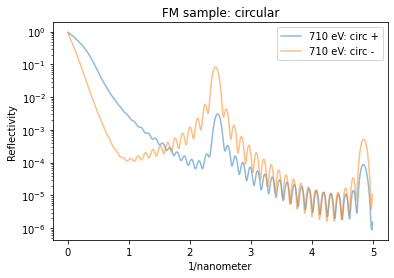

In [19]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(1, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ +'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(2, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ -'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('FM sample: circular')
plt.legend()
plt.show()

Same again with the non-magnetic sample

incoming polarizations set to: circ +
analyzer polarizations set to: unpolarized
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.568988 s
incoming polarizations set to: circ -
analyzer polarizations set to: unpolarized
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.449106 s


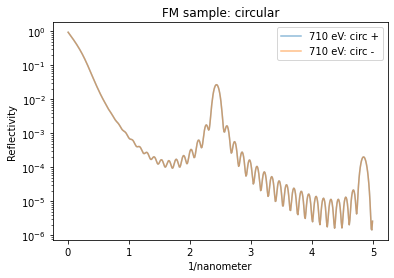

In [20]:
mag.S = S # change again to the inital sample

mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(1, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ +'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(2, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ -'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('FM sample: circular')
plt.legend()
plt.show()

#### AFM Sample

In [21]:
N_Fe = 5
N_Cr = 4

SAFM = ud.Structure('AFM Super Lattice')

DLAFM = ud.Structure('AFM Double Layer Fe+Cr')
DLAFM.add_sub_structure(Fe_uc_left, N_Fe)
DLAFM.add_sub_structure(Cr_uc, N_Cr)
DLAFM.add_sub_structure(Fe_uc_right, N_Fe)
DLAFM.add_sub_structure(Cr_uc, N_Cr)

SAFM.add_sub_structure(DLAFM, 10)

# add Si substrate
SAFM.add_substrate(substrate)

distances, _, _ = SAFM.get_distances_of_layers() # distance vector of all unit cells

mag.S = SAFM # replace the sample in the current simulation

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.772901 s
incoming polarizations set to: sigma
analyzer polarizations set to: sigma
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.732042 s
incoming polarizations set to: sigma
analyzer polarizations set to: pi
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.747576 s


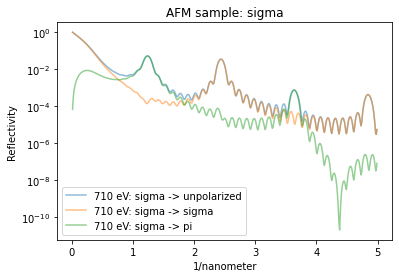

In [22]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()

mag.set_polarization(3, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> unpolarized'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> sigma'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> pi'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('AFM sample: sigma')
plt.legend()
plt.show()

incoming polarizations set to: pi
analyzer polarizations set to: unpolarized
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.555514 s
incoming polarizations set to: pi
analyzer polarizations set to: pi
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.542097 s
incoming polarizations set to: pi
analyzer polarizations set to: sigma
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.498210 s


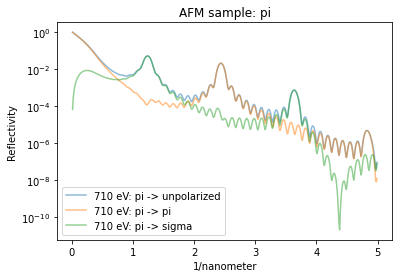

In [23]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()

mag.set_polarization(4, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> unpolarized'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(4, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> pi'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(4, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> sigma'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('AFM sample: pi')
plt.legend()
plt.show()

incoming polarizations set to: circ +
analyzer polarizations set to: unpolarized
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.538073 s
incoming polarizations set to: circ -
analyzer polarizations set to: unpolarized
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.559378 s


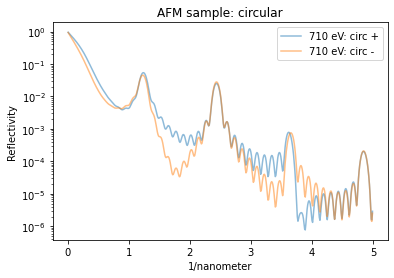

In [24]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(1, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ +'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(2, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ -'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('AFM sample: circular')
plt.legend()
plt.show()